In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
rc('text', usetex=False)
plt.rcParams.update({'font.size': 20})

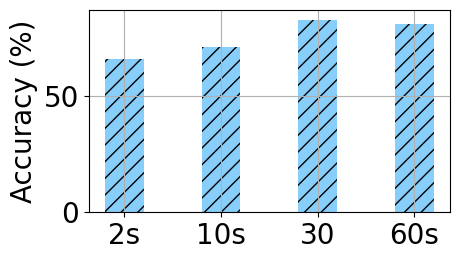

In [2]:
import numpy as np

scenario_cls_acc = [66, 71, 83, 81]
sequence_length = ['2s', '10s', '30', '60s']
fig = plt.figure(figsize=(5, 3))
plt.bar(range(len(sequence_length)), scenario_cls_acc,
         color='lightskyblue',hatch='//', width=0.4)

# plt.bar(range(len(sequence_length)), scenario_cls_acc, edgecolor='black', color='goldenrod', width=0.4)
plt.xticks(range(len(sequence_length)), sequence_length)
plt.ylabel('Accuracy (%)')
# plt.xlabel('window length')
plt.tight_layout()
plt.grid()
# plt.ylim(0, 90)
plt.y_ticks = np.arange(0, 90, 10)
plt.savefig('./scenario_length.pdf')

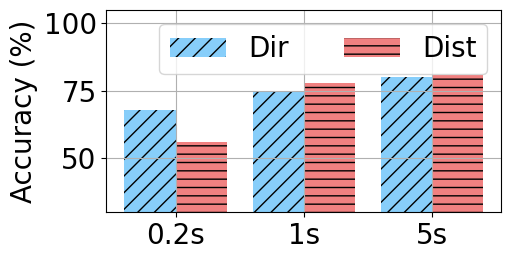

In [3]:
import numpy as np
accuracy_location = [[68, 56],[75, 78], [80, 81]]
name_location = ['0.2s', '1s', '5s']
fig = plt.figure(figsize=(5, 3))
for (i, (direction, distance)) in enumerate(accuracy_location):
    plt.bar([i], direction, color='lightskyblue',hatch='//', width=0.4)
    plt.bar([i+0.4], distance, color='lightcoral',hatch='--', width=0.4)
plt.grid()
plt.xticks(np.arange(0.2, 3.2), name_location)
plt.tight_layout()
plt.ylabel('Accuracy (%)')
# plt.xlabel('window length')
plt.legend(['Dir', 'Dist'], ncols=2)
plt.ylim([30, 105])
plt.savefig('./sound_localization_length.pdf')


(132416, 384) (132416, 384)
(91, 5, 384) (91, 5, 384)


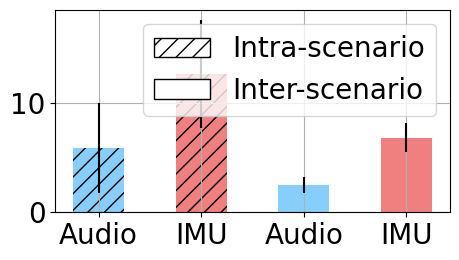

In [14]:
import numpy as np
embeddings_file = '../resources/bodysound/embeddings.npz'
embeddings = np.load(embeddings_file, allow_pickle=True)
print(embeddings['audio'].shape, embeddings['imu'].shape)
num_samples = embeddings['audio'].shape[0]

scenario = embeddings['scenario'] # [num, num_class]

def class_wise_feature(embeddings, scenario, num=10):
    num_samples, num_class = scenario.shape
    num_samples, num_features = embeddings.shape
    class_wise_features = np.zeros((num_class, num, num_features))
    for i in range(num_class):
        mask = scenario[:, i].astype(np.bool_)
        if np.sum(mask) == 0:
            continue
        embedding_mask = embeddings[mask]
        if embedding_mask.shape[0] < num:
            class_wise_features[i, :embedding_mask.shape[0], :] = embedding_mask
        else:
            class_wise_features[i] = embedding_mask[:num]
        class_wise_features[i] = np.mean(embeddings[mask], axis=0)
    return class_wise_features

def similarity_diff(class_wise_features):
    similarity = []
    for i in range(class_wise_features.shape[0]):
        scenario_feature = class_wise_features[i]
        other_feature = np.concatenate([class_wise_features[:i], class_wise_features[i+1:]], axis=0)
        other_feature = other_feature.reshape(-1, class_wise_features.shape[-1])
        self_similarity = np.mean(np.dot(scenario_feature, scenario_feature.T))
        other_similarity = np.mean(np.dot(scenario_feature, other_feature.T))
        similarity.append([self_similarity, other_similarity])
    return similarity


audio_class_wise_features = class_wise_feature(embeddings['audio'], scenario, num=5)
imu_class_wise_features = class_wise_feature(embeddings['imu'], scenario, num=5)
print(audio_class_wise_features.shape, imu_class_wise_features.shape)

audio_similariy = similarity_diff(audio_class_wise_features)
imu_similariy = similarity_diff(imu_class_wise_features)
plt.figure(figsize=(5, 3))
plt.bar(0, np.mean(audio_similariy, axis=0)[0], yerr=np.std(audio_similariy, axis=0)[0], color='lightskyblue', hatch='//', width=0.5)
plt.bar(1, np.mean(imu_similariy, axis=0)[0], yerr=np.std(imu_similariy, axis=0)[0], color='lightcoral', hatch='//', width=0.5)

plt.bar(2, np.mean(audio_similariy, axis=0)[1], yerr=np.std(audio_similariy, axis=0)[1], color='lightskyblue', width=0.5)
plt.bar(3, np.mean(imu_similariy, axis=0)[1], yerr=np.std(imu_similariy, axis=0)[1], color='lightcoral', width=0.5)
plt.xticks([0, 1, 2, 3], ['Audio', 'IMU', 'Audio', 'IMU'])
plt.grid()
plt.legend([mpatches.Patch(facecolor='w', hatch='//', edgecolor='black'), mpatches.Patch(facecolor='w', edgecolor='black')], 
           ['Intra-scenario', 'Inter-scenario'])
plt.tight_layout()
plt.savefig('./feature_similarity.pdf')
    


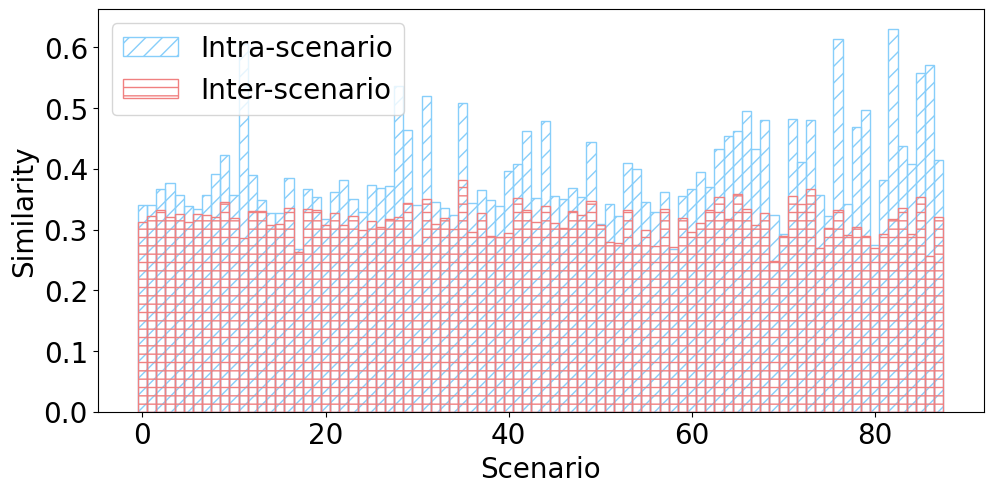

In [4]:
import numpy as np
scenario_similarities = np.loadtxt('../resources/ego4d_scenario_similarity.txt')
num_scenario = scenario_similarities.shape[0]

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.bar(np.arange(num_scenario), scenario_similarities[:, 0], color='None', hatch='//', edgecolor='lightskyblue', width=1, label='Intra-scenario')
plt.bar(np.arange(num_scenario), scenario_similarities[:, 1], color='None', hatch='--', edgecolor='lightcoral',width=1, label='Inter-scenario')
plt.tight_layout()
plt.ylabel('Similarity')
plt.xlabel('Scenario')
plt.legend()
plt.savefig('./scenario_similarity.pdf')

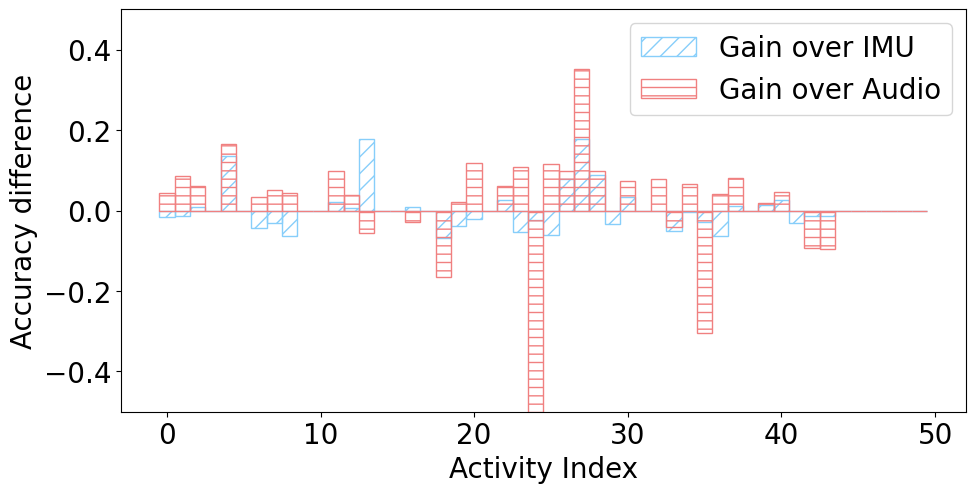

In [ ]:
import numpy as np
import torch
import torchmetrics

multimodal_gts = np.load('../resources/activity/gts.npy')
# convert to one-hot
multimodal_gts = np.eye(50)[multimodal_gts]
active_class = np.sum(multimodal_gts, axis=0) > 0
# map the multi-modal gts to active_class
multimodal_gts = multimodal_gts[:, active_class]

multimodal_preds = np.load('../resources/activity/preds.npy')
multimodal_preds = np.eye(50)[multimodal_preds]
multimodal_preds = multimodal_preds[:, active_class]

audio_gts = np.load('../resources/activity_audio/gts.npy')
audio_gts = np.eye(50)[audio_gts]
audio_gts = audio_gts[:, active_class]

audio_preds = np.load('../resources/activity_audio/preds.npy')
audio_preds = np.eye(50)[audio_preds]
audio_preds = audio_preds[:, active_class]

imu_gts = np.load('../resources/activity_imu/gts.npy')
imu_gts = np.eye(50)[imu_gts]
imu_gts = imu_gts[:, active_class]

imu_preds = np.load('../resources/activity_imu/preds.npy')
imu_preds = np.eye(50)[imu_preds]
imu_preds = imu_preds[:, active_class]

multimodal_gts = np.argmax(multimodal_gts, axis=1); multimodal_preds = np.argmax(multimodal_preds, axis=1)
audio_gts = np.argmax(audio_gts, axis=1); audio_preds = np.argmax(audio_preds, axis=1)
imu_gts = np.argmax(imu_gts, axis=1); imu_preds = np.argmax(imu_preds, axis=1)

mAP = torchmetrics.Accuracy(task='multiclass', num_classes=50, average=None)
mAP_val = mAP(torch.tensor(multimodal_gts), torch.tensor(multimodal_preds))

mAP = torchmetrics.Accuracy(task='multiclass', num_classes=50, average=None)
mAP_val_audio = mAP(torch.tensor(audio_gts), torch.tensor(audio_preds))

mAP = torchmetrics.Accuracy(task='multiclass', num_classes=50, average=None)
mAP_val_imu = mAP(torch.tensor(imu_gts), torch.tensor(imu_preds))
num_class = np.shape(mAP_val)[0]


fig, axs = plt.subplots(1, 1, figsize=(10, 5))

plt.bar(np.arange(num_class), mAP_val - mAP_val_audio, color='None', hatch='//', edgecolor='lightskyblue', width=1, label='Gain over IMU')
plt.bar(np.arange(num_class), mAP_val - mAP_val_imu, color='None', hatch='--', edgecolor='lightcoral',width=1, label='Gain over Audio')
plt.tight_layout()
plt.ylabel('Accuracy difference')
plt.xlabel('Activity Index')
plt.ylim([-.5, .5])
plt.legend()
plt.savefig('./activity_diff.pdf')


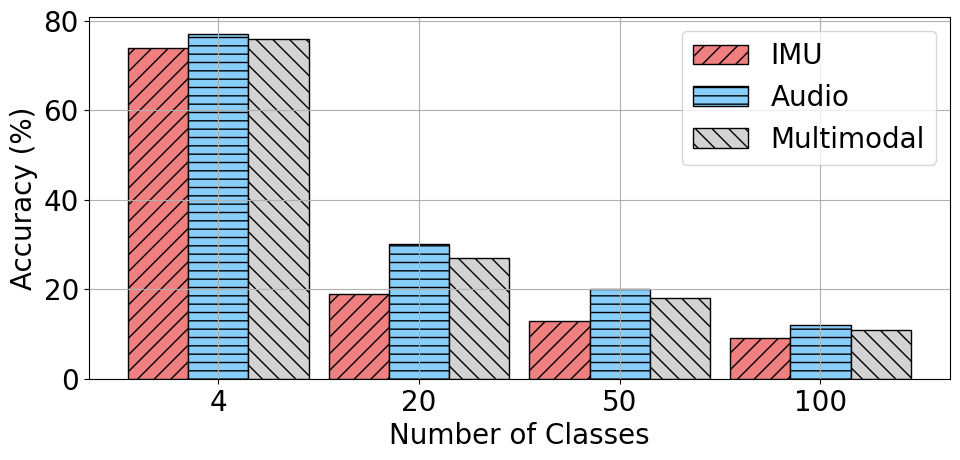

In [3]:
import numpy as np

acc_imu = [74, 19, 13, 9]
acc_audio = [77, 30, 20, 12]
acc_multimodal = [76, 27, 18, 11]
num_class = [4, 20, 50, 100]
fig = plt.figure(figsize=(10, 5))

plt.bar(np.arange(0, len(acc_imu)) - 0.3, acc_imu, edgecolor='black', color='lightcoral', width=0.3, hatch='//')
plt.bar(np.arange(0, len(acc_imu)) , acc_audio, edgecolor='black', color='lightskyblue', width=0.3, hatch='--')
plt.bar(np.arange(0, len(acc_imu)) + 0.3, acc_multimodal, edgecolor='black', color='lightgrey', width=0.3, hatch='\\\\')
plt.xticks(range(len(num_class)), num_class)

plt.ylabel('Accuracy (%)')
plt.xlabel('Number of Classes')
plt.tight_layout()  # <- HERE
plt.legend(['IMU', 'Audio', 'Multimodal'])
plt.grid()
plt.savefig('./num_class.pdf')

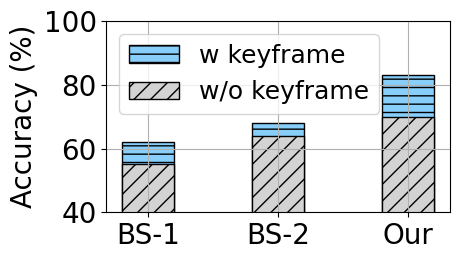

In [3]:
scenario_cls_acc = [62, 68, 83]
scenario_cls_name = ['BS-1', 'BS-2', 'Our']

scenario_cls_acc_wo_rnn = [55, 64, 70]

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.bar(range(len(scenario_cls_acc)), scenario_cls_acc, edgecolor='black', color='lightskyblue',
       hatch='--',width=0.4, label='w keyframe')

ax.bar(range(len(scenario_cls_acc_wo_rnn)), scenario_cls_acc_wo_rnn, edgecolor='black', 
       color='lightgrey', hatch='//', width=0.4, label='w/o keyframe')

ax.set_xticks(range(len(scenario_cls_acc)), scenario_cls_name)
ax.set_ylabel('Accuracy (%)')

# set legend to left of the plot
ax.legend(loc='upper left', fontsize=18)
plt.grid()
ax.set_ylim([40, 100])
plt.tight_layout()
plt.savefig('./scenario_cls.pdf')

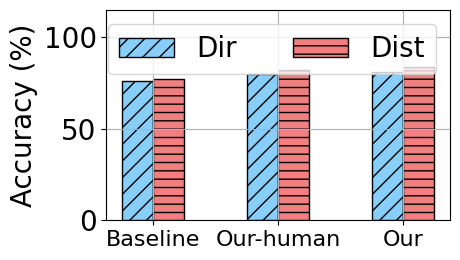

In [12]:
import numpy as np
accuracy_location = [[76, 77],  [80, 82],  [81, 84]]
name_location = ['Baseline', 'Our-human', 'Our']
fig = plt.figure(figsize=(5, 3))

for (i, (direction, distance)) in enumerate(accuracy_location):
    plt.bar([i], direction, edgecolor='black', color='lightskyblue',hatch='//', width=0.25)
    plt.bar([i+0.25], distance, edgecolor='black', color='lightcoral',hatch='--', width=0.25)

plt.xticks(np.arange(0.125, 3.125), name_location, fontsize=16)
plt.ylabel('Accuracy (%)')
plt.legend(['Dir', 'Dist'], ncols=2)
plt.ylim([0, 115])
plt.tight_layout()
plt.grid()
plt.savefig('./sound_localization.pdf')

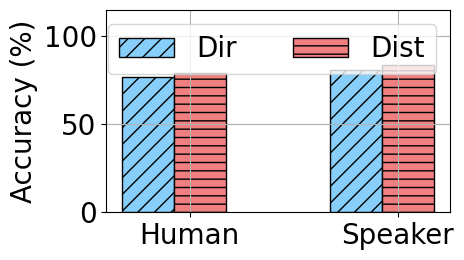

In [116]:
accuracy_location = [[77, 79], [81, 84]]
name_location = ['Human', 'Speaker']
fig = plt.figure(figsize=(5, 3))
for (i, (direction, distance)) in enumerate(accuracy_location):
    plt.bar([i], direction, edgecolor='black', color='lightskyblue',hatch='//', width=0.25)
    plt.bar([i+0.25], distance, edgecolor='black', color='lightcoral',hatch='--', width=0.25)

plt.xticks(np.arange(0.2, 2), name_location)
plt.ylabel('Accuracy (%)')
plt.legend(['Dir', 'Dist'], ncols=2)
plt.ylim([0, 115])
plt.tight_layout()
plt.grid()
plt.savefig('figs/sound_localization_human.pdf')

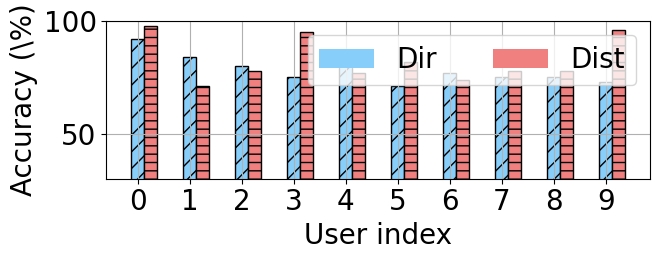

In [123]:
accuracy_location = [[92, 98], [84, 71], [80, 78], [75, 95], [86, 77], [71, 82], [77, 74], [75, 78], [75, 78], [73, 96]]
name_location = ['Direction', 'Distance', 'Direction', 'Distance']
fig = plt.figure(figsize=(7, 3))
for i, acc in enumerate(accuracy_location):
    plt.bar([i], acc[0], edgecolor='black', width=0.25,color='lightskyblue',hatch='//')
    plt.bar([i+0.25], acc[1], edgecolor='black', width=0.25,color='lightcoral',hatch='--')

plt.xticks(range(len(accuracy_location)),)
plt.ylabel('Accuracy (\%)')
plt.xlabel('User index')
# legend with different colors,
plt.legend([mpatches.Patch(facecolor='lightskyblue'), mpatches.Patch(facecolor='lightcoral')], 
           ['Dir', 'Dist'], loc='upper right', ncols=2)
plt.ylim([30, 100])
plt.tight_layout()
plt.grid()

plt.savefig('figs/sound_localization_user.pdf')

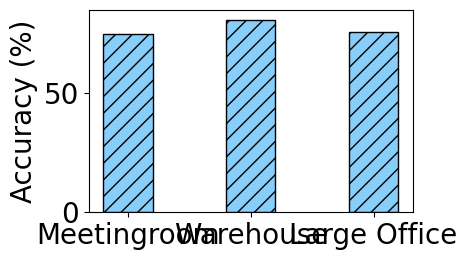

In [ ]:
accuracy_location = [75, 81, 76]
name_location = ['Meetingroom', 'Warehouse', 'Large Office']
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.bar(range(len(accuracy_location)), accuracy_location, edgecolor='black', 
      color='lightskyblue',hatch='//', width=0.4)
ax.set_xticks(range(len(name_location)), name_location)

plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.grid()
plt.savefig('figs/sound_localization_place.pdf')